# Предсказание температуры стали

## Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### План работы

- Загрузка библиотек
- Загрузка данных
- Исследовательский анализ данных
- Предобработка данных
- Создание общего датафрейма
- Создание новых признаков
- Обучение моделей
- Тестирование
- Формулирование выводов
- Написание отчета

## Подготовка

### Загрузка библиотек

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Введение констант

In [2]:
RANDOM_STATE = 80822

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

### Изучение файла data_arc

In [3]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
except:
    print('Ошибка чтения файла с данными.')

In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


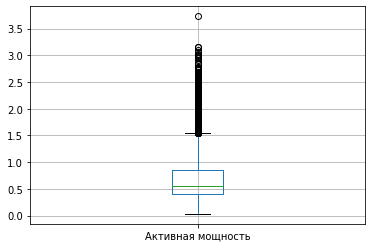

In [7]:
data_arc.boxplot(column='Активная мощность');

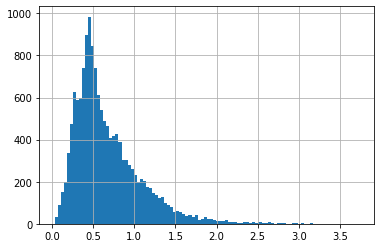

In [8]:
data_arc['Активная мощность'].hist(bins=100);

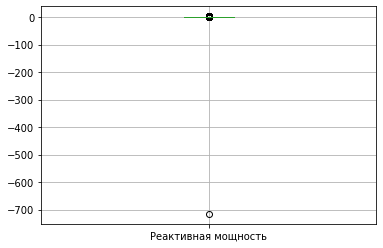

In [9]:
data_arc.boxplot(column='Реактивная мощность');

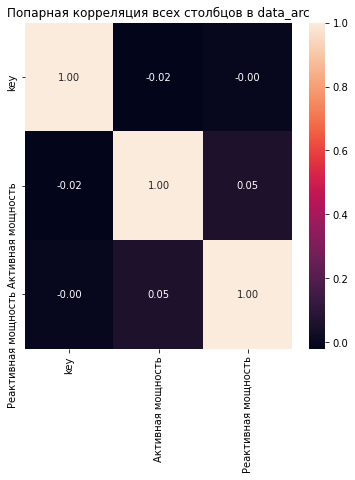

In [10]:
plt.figure(figsize=(6,6))
sns.heatmap(data_arc.corr(), annot=True, fmt='.2f')
plt.title('Попарная корреляция всех столбцов в data_arc');

В датасете `data_arc` присутствует 5 столбцов с данными об электродах:
- `key` (тип данных - int64, значения от 1 до 3241)
- `Начало нагрева дугой` (тип данных - object, значения - дата и время)
- `Конец нагрева дугой` (тип данных - object, значения - дата и время)
- `Активная мощность`(тип данных - float64, значения от 0.03 до 3.73)
- `Реактивная мощность`(тип данных - float64, значения от -715.50 до 2.67)

Пропуски отсутствуют, в столбце `Реактивная мощность` есть аномальное значение. Распределение значений в столбце `Активная мощность` имеет положительную ассиметрию. Попарно коррелирующих столбцов не найдено.

### Изучение файла data_bulk

In [11]:
try:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')    
except:
    print('Ошибка чтения файла с данными.')

In [12]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


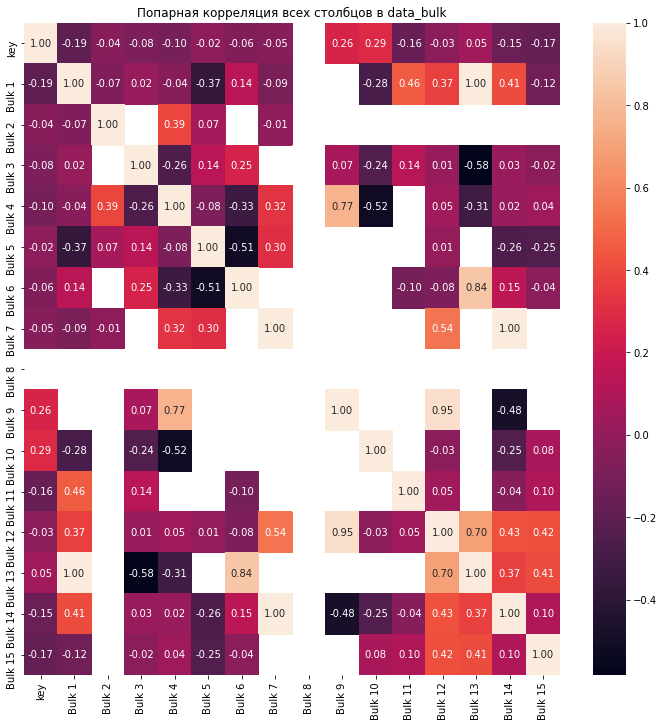

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(data_bulk.corr(), annot=True, fmt='.2f')
plt.title('Попарная корреляция всех столбцов в data_bulk');

Датасет `data_bulk` содержит данные об объеме подачи сыпучих материалов. 

15 столбцов имеют тип данных float64, столбец `key` - int64. 

В данных много пропусков вероятно свидетельствующих об отсутствии подачи отдельных сыпучих материалов в расчетный период времени (из файла `data_bulk_time`). Есть столбцы с попарной высокой корреляцией.

### Изучение файла data_bulk_time

In [16]:
try:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')    
except:
    print('Ошибка чтения файла с данными.')

In [17]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [18]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Датасет `data_bulk_time` содержит данные о времени подачи сыпучих материалов. 

15 столбцов имеют тип данных object, столбец `key` - int64.

Данные таблицы `data_bulk_time` связаны с таблицей `data_bulk`. Пропуски наблюдаются в одних и тех же местах.

### Изучение файла data_gas

In [19]:
try:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
except:
    print('Ошибка чтения файла с данными.')

In [20]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [22]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


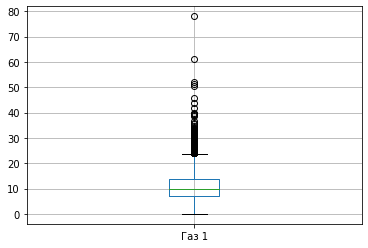

In [23]:
data_gas.boxplot(column='Газ 1');

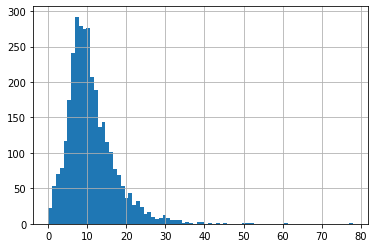

In [24]:
data_gas['Газ 1'].hist(bins=80);

В `data_gas` содержатся данные о продувке сплава газом. Таблица содержит 2 столбца: `key` с типом данных int64 и `Газ 1` с float64 и разбросом значений от 0 до 80. Распределение значений в столбце `Газ 1` имеет положительную ассиметрию.

### Изучение файла data_temp

In [25]:
try:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')    
except:
    print('Ошибка чтения файла с данными.')

In [26]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [27]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [28]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


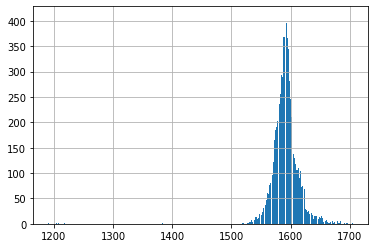

In [29]:
data_temp['Температура'].hist(bins=600);

В `data_temp` содержатся данные о результатах измерения температуры. 

Таблица содержит 3 столбца: 
- `key` с типом данных int64 
- `Время замера` с object
- `Время замера` с float64 и разбросом значений от 1191 до 1705 (имеет нормальное распределение).

### Изучение файла data_wire

In [30]:
try:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')  
except:
    print('Ошибка чтения файла с данными.')

In [31]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


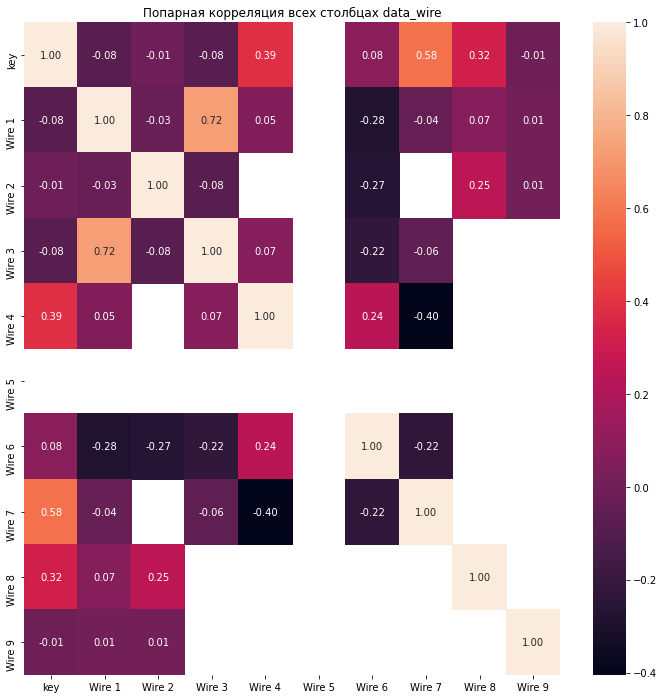

In [34]:
plt.figure(figsize=(12,12))
sns.heatmap(data_wire.corr(), annot=True, fmt='.2f')
plt.title('Попарная корреляция всех столбцах data_wire');

Датасет `data_wire` содержит данные об объеме проволочных материалов. 

9 столбцов имеют тип данных float64, столбец `key` - int64. 

В данных много пропусков вероятно свидетельствующих об отсутствии проволочных материалов в расчетный период времени (из файла `data_wire_time`). Cтолбцы с попарной высокой корреляцией - `Wire 1 и Wire 3`, средний уровень корреляции у столбцов - `Wire 7 и key`.

### Изучение файла data_wire_time

In [35]:
try:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')  
except:
    print('Ошибка чтения файла с данными.')

In [36]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Датасет `data_wire_time` содержит данные о времени проволочных материалов. 

9 столбцов имеют тип данных object, столбец `key` - int64.

Данные таблицы `data_wire_time` связаны с таблицей `data_wire`. Пропуски наблюдаются в одних и тех же местах.

### Вывод

**В датасете `data_arc` присутствует 5 столбцов с данными об электродах:**

- `key` (тип данных - int64, значения от 1 до 3241)
- `Начало нагрева дугой` (тип данных - object, значения - дата и время)
- `Конец нагрева дугой` (тип данных - object, значения - дата и время)
- `Активная мощность`(тип данных - float64, значения от 0.03 до 3.73)
- `Реактивная мощность`(тип данных - float64, значения от -715.50 до 2.67)

Пропуски отсутствуют, в столбце `Реактивная мощность` есть аномальное значение. Распределение значений в столбце `Активная мощность` имеет положительную ассиметрию. Попарно коррелирующих столбцов не найдено.

**Датасет `data_bulk` содержит данные об объеме подачи сыпучих материалов.**

15 столбцов имеют тип данных float64, столбец `key` - int64. 

В данных много пропусков вероятно свидетельствующих об отсутствии подачи отдельных сыпучих материалов в расчетный период времени (из файла `data_bulk_time`). Есть столбцы с попарной высокой корреляцией.

**Датасет `data_bulk_time` содержит данные о времени подачи сыпучих материалов.**

15 столбцов имеют тип данных object, столбец `key` - int64.

Данные таблицы `data_bulk_time` связаны с таблицей `data_bulk`. Пропуски наблюдаются в одних и тех же местах.

**В `data_gas` содержатся данные о продувке сплава газом.**

Таблица содержит 2 столбца: `key` с типом данных int64 и `Газ 1` с float64 и разбросом значений от 0 до 80. 

Распределение значений в столбце `Газ 1` имеет положительную ассиметрию.

**В `data_temp` содержатся данные о результатах измерения температуры.**

Таблица содержит 3 столбца: 
- `key` с типом данных int64 
- `Время замера` с object
- `Время замера` с float64 и разбросом значений от 1191 до 1705 (имеет нормальное распределение).

**Датасет `data_wire` содержит данные об объеме проволочных материалов.**

9 столбцов имеют тип данных float64, столбец `key` - int64. 

В данных много пропусков вероятно свидетельствующих об отсутствии проволочных материалов в расчетный период времени (из файла `data_wire_time`). Cтолбцы с попарной высокой корреляцией - `Wire 1 и Wire 3`, средний уровень корреляции у столбцов - `Wire 7 и key`.

**Датасет `data_wire_time` содержит данные о времени проволочных материалов.** 

9 столбцов имеют тип данных object, столбец `key` - int64.

Данные таблицы `data_wire_time` связаны с таблицей `data_wire`. Пропуски наблюдаются в одних и тех же местах.


## Предобработка данных
### Изменение типов данных 

In [38]:
data_arc['Начало нагрева дугой'] = data_arc['Начало нагрева дугой'].astype('datetime64[ns]')
data_arc['Конец нагрева дугой'] = data_arc['Конец нагрева дугой'].astype('datetime64[ns]')

In [39]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [40]:
data_temp['Время замера'] = data_temp['Время замера'].astype('datetime64[ns]')

### Удаление выбросов

In [41]:
data_arc = data_arc.loc[data_arc['Реактивная мощность'] > 0]

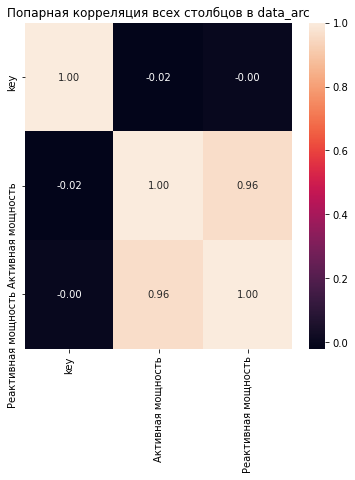

In [42]:
plt.figure(figsize=(6,6))
sns.heatmap(data_arc.corr(), annot=True, fmt='.2f')
plt.title('Попарная корреляция всех столбцов в data_arc');

Столбцы с активной и рективной мощностью коррелируют. Перед обучением один из столбцов лучше удалить.

Удалим значения с низкими температурами.

In [43]:
data_temp = data_temp.loc[data_temp['Температура'] > 1500]

In [44]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12999 non-null  int64         
 1   Время замера  12999 non-null  datetime64[ns]
 2   Температура   12999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.2 KB


### Заполнение пропусков

Пропуски в таблицах `data_bulk` и `data_wire` связаны с отсутствием подачи соответствующего материала, поэтому их можно заполнить значением 0.

In [45]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

### Вывод

В таблицах `data_arc` и `data_temp` заменены типы данных object на datetime64

В столбцах `Реактивная мощность и Температура` были удалены выбросы. 

Столбцы с активной и рективной мощностью в таблице `data_arc` после удаления выбросов коррелируют. Перед обучением один из столбцов необходимо удалить.

## Создание признаков

In [46]:
data_arc['Длительность нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [47]:
data_arc['Длит. в сек.'] = pd.to_numeric(data_arc['Длительность нагрева'].dt.seconds, downcast='integer')
data_arc = data_arc.drop('Длительность нагрева', axis=1)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длит. в сек.
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


In [48]:
data_arc['Сумм. время'] = data_arc.groupby('key')['Длит. в сек.'].transform('sum')

In [49]:
data_arc['Сред. AM'] = data_arc.groupby('key')['Активная мощность'].transform('mean')

In [50]:
data_arc['Количество'] = data_arc.groupby('key')['Длит. в сек.'].transform('count')

In [51]:
data_arc['Соотношение АМ и РМ'] = data_arc['Активная мощность']/data_arc['Реактивная мощность']
data_arc['Ср. соотн. АМ и РМ'] = data_arc.groupby('key')['Соотношение АМ и РМ'].transform('mean')
data_arc = data_arc.drop('Соотношение АМ и РМ', axis=1)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длит. в сек.,Сумм. время,Сред. AM,Количество,Ср. соотн. АМ и РМ
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1098,0.975629,5,1.538898
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1098,0.975629,5,1.538898
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1098,0.975629,5,1.538898
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1098,0.975629,5,1.538898
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1098,0.975629,5,1.538898


In [52]:
data_t = pd.pivot_table(data_temp, index = 'key',aggfunc =['first','last'], values='Температура')
data_t.columns = list(map("_".join, data_t.columns))
data_t = data_t.rename(
    columns={
        'first_Температура': 'Первая темп.',
        'last_Температура': 'Последняя темп.'
    }
)
data_t.head()

,Первая темп.,Последняя темп.
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [53]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Первая темп.     3215 non-null   float64
 1   Последняя темп.  3215 non-null   float64
dtypes: float64(2)
memory usage: 75.4 KB


In [54]:
data_t = data_t.loc[data_t['Первая темп.'] != data_t['Последняя темп.']]
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2432 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Первая темп.     2432 non-null   float64
 1   Последняя темп.  2432 non-null   float64
dtypes: float64(2)
memory usage: 57.0 KB


### Вывод

Созданы дополнительные признаки для каждого `key`:
- Суммарная длительность нагрева 
- Количество нагревов
- Среднее соотношение активной мощности к реактивной
- Полная мощность
- Средняя активная мощность
- Значение первого замера температуры
- Значение последнего замера температуры (целевой признак)

## Создание общего датафрейма

In [55]:
data = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой','Реактивная мощность','Активная мощность','Длит. в сек.'], axis=1)

In [56]:
data = data.drop_duplicates().reset_index(drop=True)
data = data.merge(data_t, on='key', how='left')
data.head()

,key,Сумм. время,Сред. AM,Количество,Ср. соотн. АМ и РМ,Первая темп.,Последняя темп.
0,1,1098,0.975629,5,1.538898,1571.0,1613.0
1,2,811,0.763150,4,1.551834,1581.0,1602.0
2,3,655,0.505176,5,1.583120,1596.0,1599.0
3,4,741,0.802313,4,1.563487,1601.0,1625.0
4,5,869,0.836793,4,1.480428,1576.0,1602.0


In [57]:
data = data.merge(data_gas, on='key', how='left')

In [58]:
bulk = data_bulk.drop(['Bulk 7', 'Bulk 8','Bulk 9','Bulk 13'], axis=1)
data = data.merge(bulk, on='key', how='left')

In [59]:
wire = data_wire.drop(['Wire 3', 'Wire 5'], axis=1)
data = data.merge(wire, on='key', how='left')

Перед объединением таблиц удалим столбцы с высокой попарной корреляцией, обнаруженной на стадии исследовательского анализа данных. Столбцы `Bulk 8, Wire 5` удалены из-за отсутствия достаточного количества в них данных.

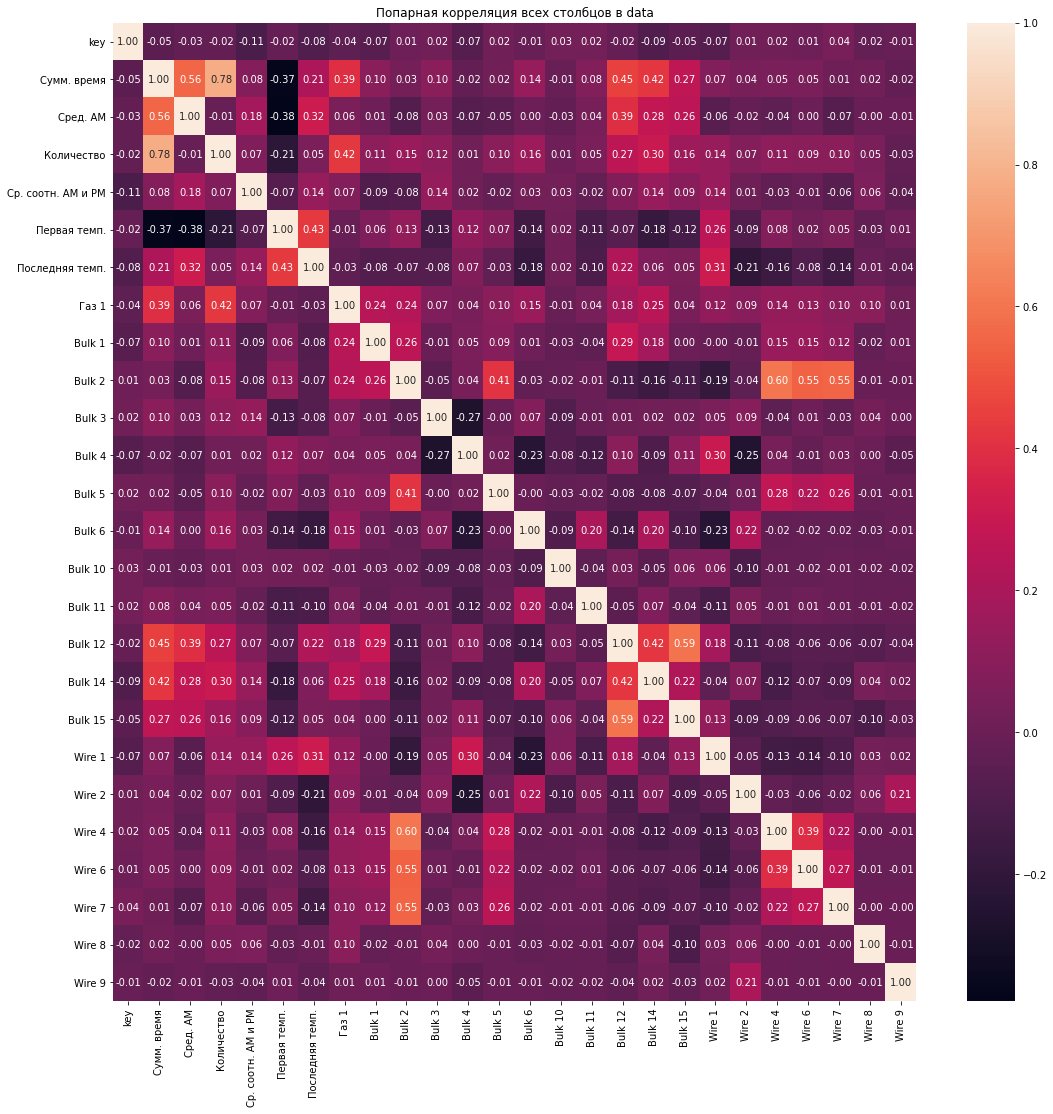

In [60]:
plt.figure(figsize=(18,18))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Попарная корреляция всех столбцов в data');

Матрица корреляции признаков показывает, что признаками с высокой корреляцией в объединенном датафрейме являются: `Суммарное время, Bulk 2, Bulk 12`. Удалим их.

In [61]:
data = data.drop(['Сумм. время','Bulk 2', 'Bulk 12'], axis=1)

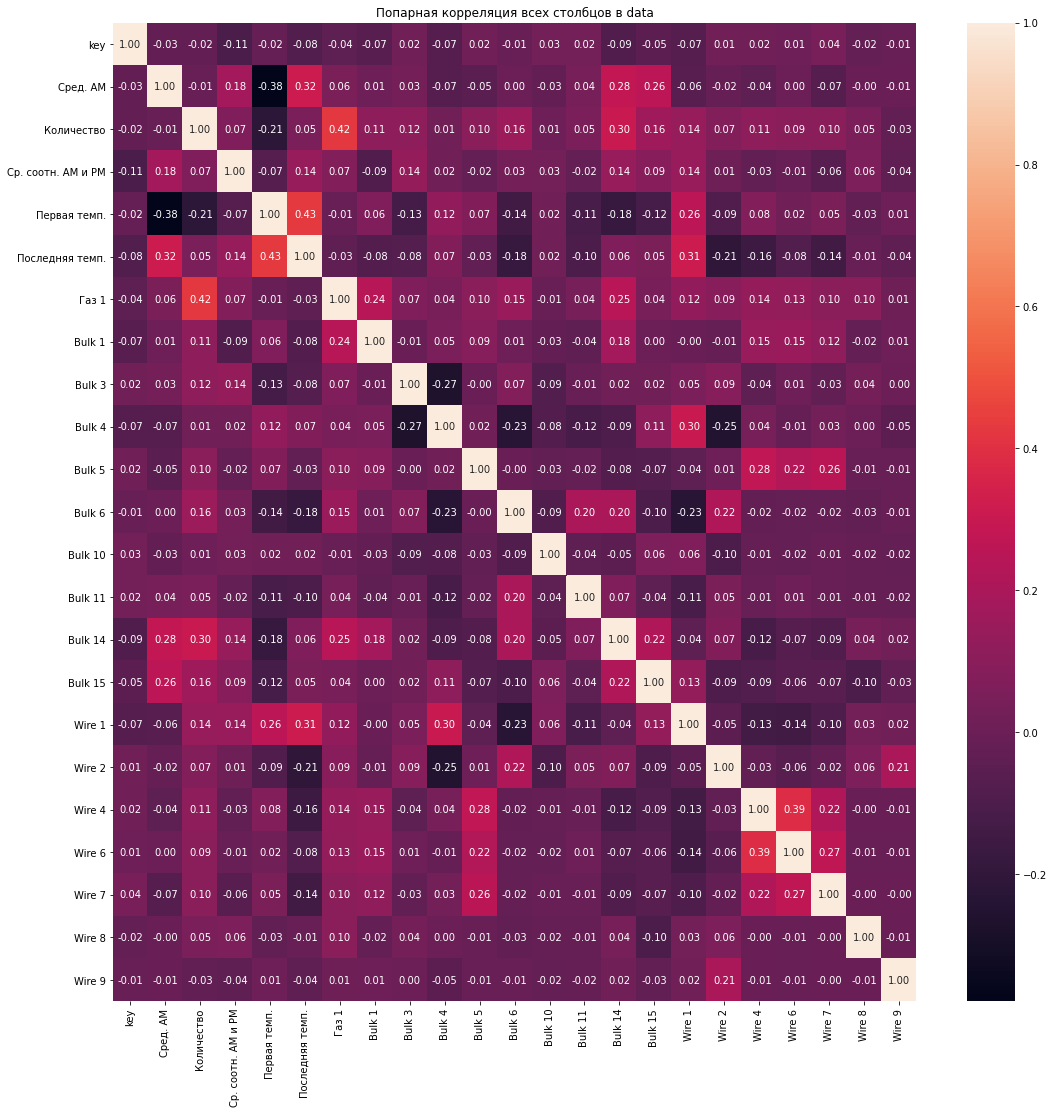

In [62]:
plt.figure(figsize=(18,18))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Попарная корреляция всех столбцов в data');

После удаления столбцов с высокой попарной корреляцией, у нас остался датафрейм с корреляцией столбцов меньше 0.5. Можно обучать модели на таких данных.

In [63]:
data = data.drop('key', axis=1)
data = data.dropna()

In [64]:
data.head()

,Сред. AM,Количество,Ср. соотн. АМ и РМ,Первая темп.,Последняя темп.,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,Bulk 11,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,0.975629,5,1.538898,1571.0,1613.0,29.749986,0.0,0.0,43.0,0.0,...,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.763150,4,1.551834,1581.0,1602.0,12.555561,0.0,0.0,73.0,0.0,...,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.505176,5,1.583120,1596.0,1599.0,28.554793,0.0,0.0,34.0,0.0,...,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.802313,4,1.563487,1601.0,1625.0,18.841219,0.0,0.0,81.0,0.0,...,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.836793,4,1.480428,1576.0,1602.0,5.413692,0.0,0.0,78.0,0.0,...,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0


In [65]:
#к.р.
data.describe()

,Сред. AM,Количество,Ср. соотн. АМ и РМ,Первая темп.,Последняя темп.,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,Bulk 11,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
count,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,...,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000,2292.000000
mean,0.670206,4.699389,1.361955,1587.294066,1593.369983,11.399468,3.439354,47.667103,37.143543,2.682810,...,4.149651,154.105585,120.142234,102.430779,17.718618,0.311499,0.994621,0.006463,0.316337,0.322232
std,0.197673,1.610187,0.131677,23.746881,11.181457,6.401243,12.428276,75.554794,58.653842,22.579936,...,22.263056,81.581301,84.744646,43.650477,33.803546,4.795850,8.762320,0.207358,4.437938,3.484125
min,0.186226,1.000000,0.687735,1519.000000,1541.000000,0.008399,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.526451,4.000000,1.294691,1571.000000,1587.000000,7.302420,0.000000,0.000000,0.000000,0.000000,...,0.000000,105.000000,0.000000,73.204559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.646869,5.000000,1.373640,1587.000000,1593.000000,10.109138,0.000000,0.000000,0.000000,0.000000,...,0.000000,149.000000,107.000000,101.058359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.793885,6.000000,1.441981,1603.000000,1598.000000,14.221982,0.000000,80.000000,77.000000,0.000000,...,0.000000,204.000000,204.000000,128.075222,23.137141,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.421416,16.000000,1.782164,1660.000000,1653.000000,77.995040,185.000000,454.000000,281.000000,603.000000,...,313.000000,636.000000,405.000000,330.314424,282.780152,113.231044,180.454575,8.490040,102.762401,62.025600


### Вывод

Перед объединением таблиц мы удалили столбцы с высокой попарной корреляцией, обнаруженной на стадии исследовательского анализа данных. Столбцы `Bulk 8, Wire 5` удалены из-за отсутствия достаточного количества в них данных.

После удаления столбцов с высокой попарной корреляцией, у нас остался датафрейм с корреляцией столбцов меньше 0.5.

Для обучения модели был создан общий датасет с признаками:

- Средняя активная мощность
- Количество нагревов
- Среднее соотношение активной мощности к реактивной
- Значение первого замера температуры
- Значение последнего замера температуры (целевой признак)
- Объем инертного газа
- Данные о сыпучих материалах 1, 3, 4, 5, 6, 10, 11, 14, 15
- Данные о проволочных материалах 1, 2, 4, 6, 7, 8, 9

## Обучение моделей
### Разделение на выборки

In [66]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

display(data_train.shape)
display(data_test.shape)

(1719, 22)

(573, 22)

In [67]:
features_train = data_train.drop(['Последняя темп.'],axis=1)
target_train = data_train['Последняя темп.']

features_test = data_test.drop(['Последняя темп.'],axis=1)
target_test = data_test['Последняя темп.']

### Линейная регрессия

In [68]:
model_lr = LinearRegression(normalize=True, fit_intercept=True)
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_train)
mae_lr = mean_absolute_error(target_train, predictions_lr)

m_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(model_lr, features_train, target_train, cv=5, scoring=m_scorer)

print('MAE модели линейной регрессии:', mae_lr)
print('Метрика на кросс-валидации:', scores.mean())

MAE модели линейной регрессии: 5.988469672331613
Метрика на кросс-валидации: 6.533521241491738


### Случайный лес

In [69]:
model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

parametrs_forest = {'max_depth': range (1,10),
                    'n_estimators': range (1,100,10)}

RandomizedSearchCV_forest = RandomizedSearchCV(model_forest, parametrs_forest, cv=5, verbose=1, n_iter=10, scoring=mean_absolute_error, random_state=RANDOM_STATE)
RandomizedSearchCV_forest.fit(features_train, target_train)

warnings.filterwarnings("ignore")
RandomizedSearchCV_forest.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=1775    1603.0
331     1594.0
667     1588.0
335     1594.0
1701    1584.0
         ...  
2215    1597.0
137     1592.0
1678    1592.0
748     1590.0
2137    1593.0
Name: Последняя темп., Length: 344, dtype: float64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retur

{'n_estimators': 51, 'max_depth': 6}

In [70]:
model_forest = RandomForestRegressor(n_estimators = 51 , max_depth = 6, random_state=RANDOM_STATE)

model_forest.fit(features_train, target_train)
predictions_forest = model_forest.predict(features_train)
mae_forest = mean_absolute_error(target_train, predictions_forest)

print('MAE модели случайного леса:', mae_forest)

MAE модели случайного леса: 5.543237767453177


### CatBoostRegressor

In [71]:
model_cat = CatBoostRegressor(random_state=RANDOM_STATE)
    
parametrs_cat= {'depth': range (2, 15, 2),
                'iterations': range (110, 211, 25)}

RandomizedSearchCV_cat = RandomizedSearchCV(model_cat, parametrs_cat, cv=5, verbose=1, scoring=mean_absolute_error, random_state=RANDOM_STATE)
RandomizedSearchCV_cat.fit(features_train, target_train)

warnings.filterwarnings("ignore")

display(RandomizedSearchCV_cat.best_params_)
RandomizedSearchCV_cat.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Learning rate set to 0.153132
0:	learn: 10.9825299	total: 48.1ms	remaining: 10.1s
1:	learn: 10.6926499	total: 49.5ms	remaining: 5.14s
2:	learn: 10.5016699	total: 50.7ms	remaining: 3.49s
3:	learn: 10.2637099	total: 51.9ms	remaining: 2.67s
4:	learn: 10.0487660	total: 53ms	remaining: 2.17s
5:	learn: 9.8561087	total: 54.3ms	remaining: 1.84s
6:	learn: 9.7455401	total: 55.3ms	remaining: 1.6s
7:	learn: 9.6350672	total: 56.3ms	remaining: 1.42s
8:	learn: 9.4452543	total: 57.4ms	remaining: 1.28s
9:	learn: 9.3050208	total: 58.5ms	remaining: 1.17s
10:	learn: 9.2093375	total: 59.6ms	remaining: 1.08s
11:	learn: 9.0757494	total: 60.6ms	remaining: 1s
12:	learn: 8.9897571	total: 61.7ms	remaining: 935ms
13:	learn: 8.9074950	total: 62.7ms	remaining: 878ms
14:	learn: 8.8199830	total: 63.8ms	remaining: 829ms
15:	learn: 8.7707113	total: 65ms	remaining: 788ms
16:	learn: 8.7194271	total: 66ms	remaining: 749ms
17:	learn: 8.6070481	total: 67ms	remaini

{'iterations': 210, 'depth': 4}

nan

In [72]:
model_cat = CatBoostRegressor(depth=4, iterations=210, random_state=RANDOM_STATE)

model_cat.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_train)
mae_cat = mean_absolute_error(target_train, predictions_cat)

print('MAE модели CatBoostRegressor:', mae_cat)

Learning rate set to 0.158631
0:	learn: 10.7407447	total: 1.37ms	remaining: 287ms
1:	learn: 10.4502888	total: 2.76ms	remaining: 287ms
2:	learn: 10.1800286	total: 4.28ms	remaining: 295ms
3:	learn: 9.9656918	total: 5.93ms	remaining: 305ms
4:	learn: 9.7720627	total: 7.68ms	remaining: 315ms
5:	learn: 9.5931552	total: 9.91ms	remaining: 337ms
6:	learn: 9.4861352	total: 11.6ms	remaining: 337ms
7:	learn: 9.3988041	total: 13.8ms	remaining: 349ms
8:	learn: 9.2394262	total: 15.5ms	remaining: 346ms
9:	learn: 9.1329197	total: 17.2ms	remaining: 345ms
10:	learn: 9.0472987	total: 19.1ms	remaining: 346ms
11:	learn: 8.9037306	total: 20.9ms	remaining: 345ms
12:	learn: 8.8363163	total: 22.6ms	remaining: 342ms
13:	learn: 8.7636432	total: 24.3ms	remaining: 340ms
14:	learn: 8.6600514	total: 25.5ms	remaining: 332ms
15:	learn: 8.6076005	total: 26.7ms	remaining: 324ms
16:	learn: 8.5546777	total: 28ms	remaining: 317ms
17:	learn: 8.4471664	total: 29.3ms	remaining: 312ms
18:	learn: 8.3874532	total: 31.1ms	remainin

### LightGBM

In [73]:
model_LGB = LGBMRegressor(random_state=RANDOM_STATE)
    
parametrs_LGB= {'max_depth': range (2, 15, 2), 
                'verbose': range (0, 10)}

RandomizedSearchCV_LGB = RandomizedSearchCV(model_LGB, parametrs_LGB, cv=5, verbose=1, scoring=mean_absolute_error, random_state=RANDOM_STATE)
RandomizedSearchCV_LGB.fit(features_train, target_train)

warnings.filterwarnings("ignore")
display(RandomizedSearchCV_LGB.best_params_)
RandomizedSearchCV_LGB.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.856909
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.460963
[LightGBM] [Debug] init for col-wise cost 0.308545 seconds, init for row-wise cost 0.301644 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.412355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1945
[LightGBM] [Info] Number of data points in the train set: 1375, number of used features: 17
[LightGBM] [Info] Start training from score 1593.200727
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

{'verbose': 5, 'max_depth': 4}

nan

In [74]:
model_LGB = LGBMRegressor(verbose=5, max_depth=4, random_state=RANDOM_STATE)

model_LGB.fit(features_train, target_train)
predictions_LGB = model_LGB.predict(features_train)
mae_LGB = mean_absolute_error(target_train, predictions_LGB)

print('MAE модели LightGBM:', mae_LGB)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.859075
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.461075
[LightGBM] [Debug] init for col-wise cost 0.000464 seconds, init for row-wise cost 0.000506 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 17
[LightGBM] [Info] Start training from score 1593.250727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves 

### Константная модель

In [75]:
predictions_const = pd.Series(target_train.mean(), index=target_train.index)

mae_const = mean_absolute_error(target_train, predictions_const)

print('MAE константной модели:', mae_const)

MAE константной модели: 7.9894590825395095


### Сравнение моделей

In [78]:
models = [['Линейная регрессия', 6.53],
          ['Случайный лес', 5.54],
          ['CatBoostRegressor', 4.14],
          ['LightGBM', 4.48],
          ['Константная модель', 7.98]] 
    
df = pd.DataFrame(models, columns =['Модель','МАЕ на обучающей выборке']) 
df

,Модель,МАЕ на обучающей выборке
0,Линейная регрессия,6.53
1,Случайный лес,5.54
2,CatBoostRegressor,4.14
3,LightGBM,4.48
4,Константная модель,7.98


### Вывод

Лучшее MAE получено на обучающей выборке у CatBoostRegressor с гиперпарпаметрами depth=4, iterations=210.

## Тестирование лучшей модели

In [79]:
predictions_cat_test = model_cat.predict(features_test)
mae_cat_test = mean_absolute_error(target_test, predictions_cat_test)

print('MAE модели CatBoostRegressor на тестовой выборке:', mae_cat_test)

MAE модели CatBoostRegressor на тестовой выборке: 5.829191825157012


## График важности признаков

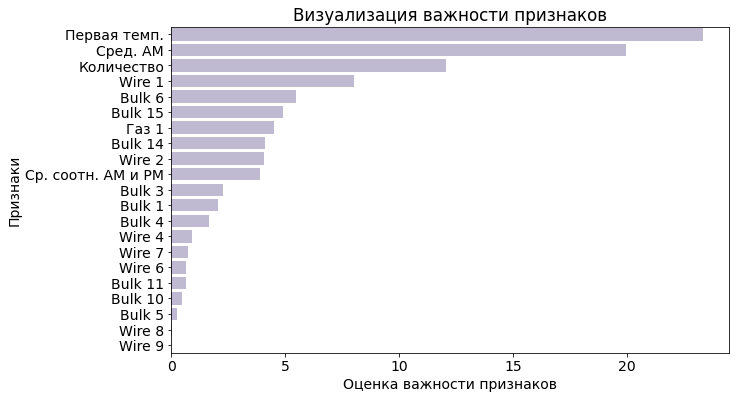

In [80]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    plt.gcf().set_size_inches(10, 6)
    plt.rcParams.update({'font.size': 14})
    
    ax = sns.barplot(x=feature_imp, y=feature_imp.index, orient='h', color = '#BDB5D5')
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')


        
chart_feature_imp(model_cat)

При построении графика важности признаков для обученной модели мы видим, что 5 самых важных признаков:

- Значение первого замера температуры,
- Средняя активная мощность,
- Количество нагревов,
- Wire 1,
- Bulk 6.

Два самых наименее важных признака:

- Wire 8,
- Wire 9.

Для ускорени процесса обучения, можно удалить их из таблицы признаков для обучения.

## Общий вывод (Отчет)

Мы получили данные, выгруженные из разных источников: 7 датафреймов с информацией об электродах, объеме и времени подачи сыпучих материалов, продувке сплава газом, объеме и времени подачи проволочных материалов, результаты измерения температуры.

Каждый из файлов был открыт, у них изучены:
- типы данных,
- наличие пропусков,
- наличие аномальных значений,
- распределения значений,
- попарная корреляция столбцов.

Перед обучением данные были предобработаны:
- В таблицах `data_arc` и `data_temp` заменены типы данных object на datetime64
- В столбцах `Реактивная мощность и Температура` были удалены выбросы.
- Пропуски в таблицах `data_bulk` и `data_wire` заполнены значением 0, так как они связаны с отсутствием подачи соответствующих материалов.
- Уменьшено количество столбцов с коррелирующими значениями (удалены столбцы `Реактивная мощность, Суммарная длительность нагрева, Bulk 2, Bulk 7, Bulk 9, Bulk 12, Bulk 13, Wire 3`).
- Столбцы `Bulk 8, Wire 5` удалены из-за отсутствия достаточного количества в них данных, столбец `key` удален из-за отсутствия в нем информации, необходимой для обучения модели.
- Для каждого номера партии созданы дополнительные признаки.
- Номера партий, в которых не хватает данных были удалены.



После удаления всех столбцов с высокой попарной корреляцией, у нас остался датафрейм с корреляцией столбцов меньше 0.5.

Для обучения модели был создан общий датасет с признаками:
- Суммарная длительность нагрева
- Средняя активная мощность
- Количество нагревов
- Среднее соотношение активной мощности к реактивной
- Значение первого замера температуры
- Значение последнего замера температуры (целевой признак)
- Объем инертного газа
- Данные о сыпучих материалах 1, 3, 4, 5, 6, 10, 11, 14, 15
- Данные о проволочных материалах 1, 2, 4, 6, 7, 8, 9

Датасет был разделен в соотношении 75/25 на обучающую и тестовую выборку. Обучены 4 модели (линейная регрессия, случайный лес, CatBoostRegressor и LightGBM). При сравнении полученных метрик между собой и с константной моделью, лучшие результаты показала CatBoostRegressor с гиперпарпаметрами depth=4, iterations=210, RANDOM_STATE = 80822, остальные гиперпараметры - дефолтные.

При построении графика важности признаков для обученной модели мы увидели, что 5 самых важных признаков:

- Значение первого замера температуры,
- Средняя активная мощность,
- Количество нагревов,
- Wire 1,
- Bulk 6.

Два наименее важных признака:

- Wire 8,
- Wire 9.

Для ускорени процесса обучения, можно удалить их из таблицы признаков для обучения.

На тестовой выборке при обучении CatBoostRegressor была получена МАЕ = 5.82.

То есть модель в предсказании температуры в среднем ошибается на 5.82 градуса.